In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
from PIL import Image
import tifffile
import cv2
from cv2 import dnn_superres

In [2]:
# image information

image = Image.open("20240826_H1-TXK6Z4X_A1_sk24-001-a1-4.tif")
dpi = image.info.get("dpi", (72, 72))
print(f"Using Pillow - DPI: {dpi}, Size: {image.size}, Mode: {image.mode}")

with tifffile.TiffFile("20240826_H1-TXK6Z4X_A1_sk24-001-a1-4.tif") as tif:
    print(f"Using TiffFile - Total Pages: {len(tif.pages)}")
    for i, page in enumerate(tif.pages):
        print(f"Page {i + 1}:")
        print(f"  Size: {page.shape}")
        print(f"  XResolution: {page.tags.get('XResolution')}")
        print(f"  YResolution: {page.tags.get('YResolution')}")
        print(f"  Compression: {page.compression}")


Using Pillow - DPI: (5491.886176757813, 5491.886176757813), Size: (3200, 3000), Mode: RGB
Using TiffFile - Total Pages: 1
Page 1:
  Size: (3000, 3200, 3)
  XResolution: TiffTag 282 XResolution @19873768 RATIONAL @19874000 = (8856207, 4096)
  YResolution: TiffTag 283 YResolution @19873780 RATIONAL @19874008 = (8856207, 4096)
  Compression: 5


In [3]:
image = Image.open("tissue_hires_image.png")
dpi = image.info.get("dpi", (72, 72))
print(f"Using Pillow - DPI: {dpi}, Size: {image.size}, Mode: {image.mode}")

Using Pillow - DPI: (72, 72), Size: (6000, 4336), Mode: RGB


In [3]:
# models link: 
# https://github.com/Saafke/EDSR_Tensorflow/blob/master/models/EDSR_x4.pb
# https://github.com/fannymonori/TF-LapSRN/blob/master/export/LapSRN_x8.pb

sr = dnn_superres.DnnSuperResImpl_create()
path = "EDSR_x4.pb"
sr.readModel(path)

sr.setModel("edsr", 4)
image = cv2.imread("test.png")
result = sr.upsample(image)
cv2.imwrite("test_edsr_x4.png", result)

# traditional method - bicubic
bicubic = cv2.resize(image, (result.shape[1], result.shape[0]), interpolation=cv2.INTER_CUBIC)
# save the image
cv2.imwrite('bicubic_test.png', bicubic)

True

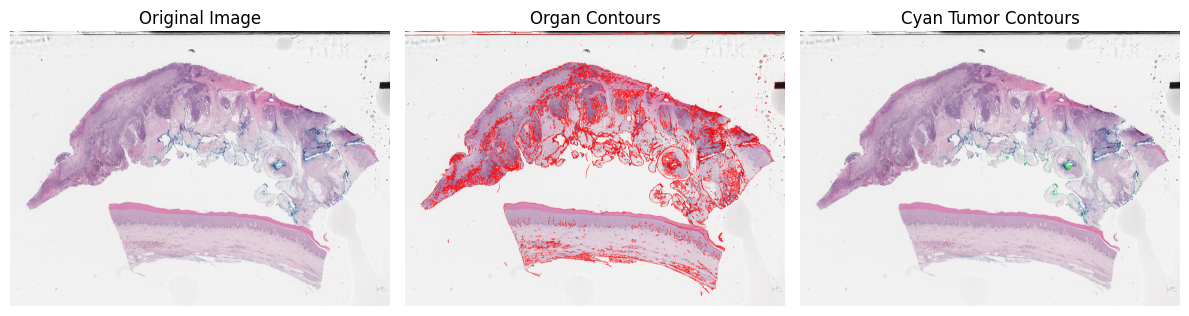

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 加载图片
image_path = "tissue_hires_image.png"  # 替换为你的图片路径
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 转换为 HSV 颜色空间
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 组织轮廓提取 - 使用灰度图和边缘检测
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# 找到组织轮廓
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = image_rgb.copy()
cv2.drawContours(contour_image, contours, -1, (255, 0, 0), 2)  # 用蓝色画组织轮廓

# 青色区域掩膜
lower_cyan = np.array([85, 50, 50])   # 青色范围 (HSV)
upper_cyan = np.array([100, 255, 255])
cyan_mask = cv2.inRange(hsv_image, lower_cyan, upper_cyan)

# 青色区域轮廓提取
cyan_contours, _ = cv2.findContours(cyan_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
tumor_image = image_rgb.copy()
cv2.drawContours(tumor_image, cyan_contours, -1, (0, 255, 0), 2)  # 用绿色画青色肿瘤轮廓

# 显示结果
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Organ Contours")
plt.imshow(contour_image)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Cyan Tumor Contours")
plt.imshow(tumor_image)
plt.axis("off")

plt.tight_layout()
plt.show()


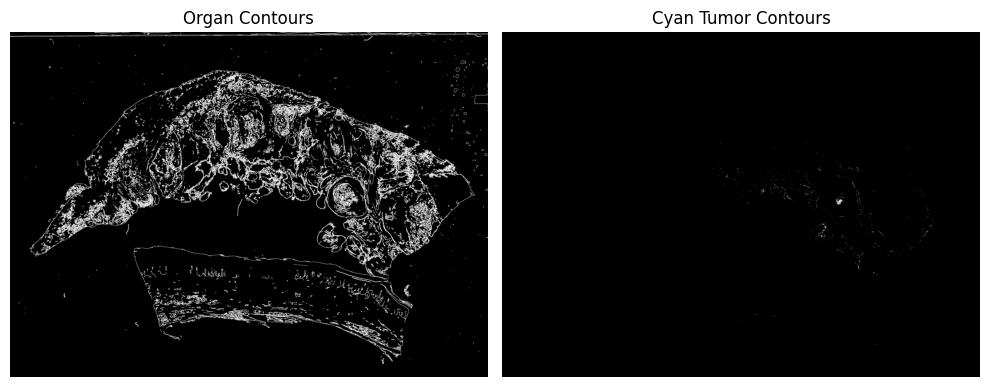

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 加载图片
image_path = "tissue_hires_image.png"  # 替换为你的图片路径
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 转换为 HSV 颜色空间
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 组织轮廓提取 - 使用灰度图和边缘检测
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# 找到组织轮廓
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 创建黑色背景图并绘制组织轮廓
organ_contours_image = np.zeros_like(image_rgb)
cv2.drawContours(organ_contours_image, contours, -1, (255, 255, 255), 2)  # 用白色画组织轮廓

# 青色区域掩膜
lower_cyan = np.array([85, 50, 50])   # 青色范围 (HSV)
upper_cyan = np.array([100, 255, 255])
cyan_mask = cv2.inRange(hsv_image, lower_cyan, upper_cyan)

# 青色区域轮廓提取
cyan_contours, _ = cv2.findContours(cyan_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 创建黑色背景图并绘制青色肿瘤轮廓
tumor_contours_image = np.zeros_like(image_rgb)
cv2.drawContours(tumor_contours_image, cyan_contours, -1, (255, 255, 255), 2)  # 用白色画青色肿瘤轮廓

# 保存结果图像
cv2.imwrite("organ_contours.png", cv2.cvtColor(organ_contours_image, cv2.COLOR_RGB2BGR))
cv2.imwrite("tumor_contours.png", cv2.cvtColor(tumor_contours_image, cv2.COLOR_RGB2BGR))

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Organ Contours")
plt.imshow(organ_contours_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Cyan Tumor Contours")
plt.imshow(tumor_contours_image)
plt.axis("off")

plt.tight_layout()
plt.show()
